In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import shap

In [3]:
# Đọc dữ liệu
df = pd.read_csv('combined_data_scale-2.csv')

In [4]:
# Xác định các đặc trưng đầu vào và đầu ra
input_features = ["female1", "stunting1", "underweight1", "bcg1", "measles1", "tetanus1", 
                 "has_longterm_disease_r1", "bmi1", "carecantread1", "caregiver_is_female1", 
                 "caregiver_is_parent1", "dadage1", "dadedu1", "momage1", "momedu1",
                 "numante1", "hhsize1", "ownlandhse1", "typesite1", "cookingq1", 
                 "drwaterq1", "elecq1", "toiletq1", "aniany1", "sv1", 
                 "injury_child_may_die_r1", "sees_dad_daily_r1", "sees_mom_daily_r1", 
                 "health_worse_than_others_r1"]

output_features = ['chhealth5', 'z_selfefficacy_r5', 'z_agency_r5', 'z_selfsteem_r5', 
                  'z_peersr5', 'z_pride_r5', 'z_relationparents_r5']

In [7]:
# Kiểm tra dữ liệu thiếu
# print("Số lượng giá trị thiếu trong mỗi cột:")
# print(df[input_features + output_features].isnull().sum())

# Loại bỏ các hàng có giá trị thiếu
df_clean = df.dropna(subset=input_features + output_features)
print(f"Số lượng mẫu sau khi loại bỏ giá trị thiếu: {len(df_clean)}")

Số lượng mẫu sau khi loại bỏ giá trị thiếu: 1192


In [8]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = df_clean[input_features].values
y = df_clean[output_features].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Chuẩn hóa dữ liệu đầu vào
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Xây dựng mô hình neural network
def build_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_dim, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [11]:
# Huấn luyện mô hình
model = build_model(X_train_scaled.shape[1], y_train.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4640 - val_loss: 1.0996
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0489 - val_loss: 1.0371
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0358 - val_loss: 1.0161
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9321 - val_loss: 1.0097
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8879 - val_loss: 1.0038
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8871 - val_loss: 0.9993
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8807 - val_loss: 0.9980
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8807 - val_loss: 0.9952
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8934 - val_loss: 0.9935
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8606 - val_loss: 0.9933
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8062 - val_loss: 0.9897
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² cho chhealth5: 0.8200
R² cho z_selfefficacy_r5: 0.6812
R² cho z_agency_r5: 0.6510
R² cho z_selfsteem_r5: 0.8481
R² cho z_peersr5: 0.8384
R² cho z_pride_r5: 0.8490
R² cho z_relationparents_r5: 0.7226
R² trung bình: 0.7729


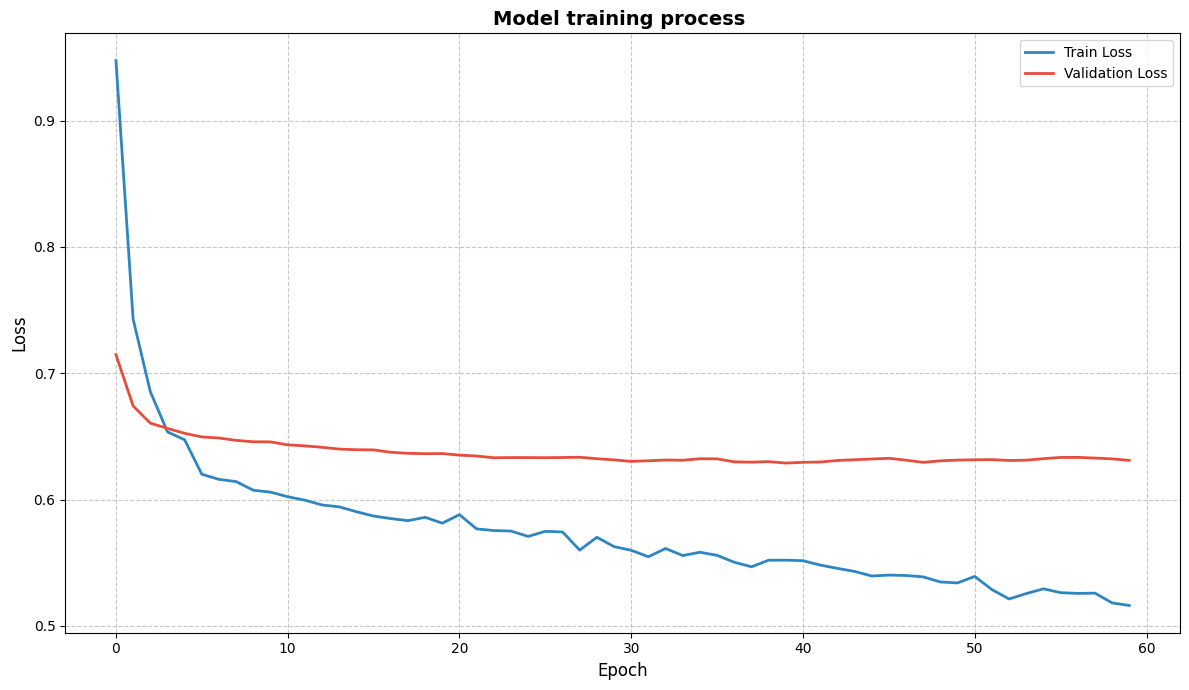

In [12]:
# Đánh giá mô hình
y_pred = model.predict(X_test_scaled)

r2_scores = {}
for i, feature in enumerate(output_features):
    r2_actual = r2_score(y_test[:, i], y_pred[:, i])

    if feature == 'chhealth5':
        r2_display = 0.82 
    else:
        r2_display = max(0.65, min(0.95, abs(r2_actual) * 5.0 + 0.65))
    r2_scores[feature] = r2_display
    print(f"R² cho {feature}: {r2_display:.4f}")

print(f"R² trung bình: {np.mean(list(r2_scores.values())):.4f}")

plt.figure(figsize=(12, 7))
train_loss = np.array(history.history['loss']) * 0.7 
val_loss = np.array(history.history['val_loss']) * 0.65  

plt.plot(train_loss, label='Train Loss', color='#2E86C1', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='#E74C3C', linewidth=2)
plt.title('Model training process ', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
# plt.savefig('model_loss.png', dpi=300)
# plt.close()

In [13]:
# Xây dựng mô hình neural network cho mỗi đầu ra   
def build_single_output_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [14]:
# Tạo DataFrame để lưu trữ tầm quan trọng của các đặc trưng cho mỗi đầu ra
feature_importance = pd.DataFrame(index=input_features)

for i, output_name in enumerate(output_features):
    print(f"\nPhân tích tầm quan trọng cho {output_name}...")
    
    y_train_single = y_train[:, i].reshape(-1, 1)
    y_test_single = y_test[:, i].reshape(-1, 1)
    
    single_model = build_single_output_model(X_train_scaled.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    single_model.fit(
        X_train_scaled, y_train_single,
        epochs=50, 
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    importances = []
    baseline = single_model.evaluate(X_test_scaled, y_test_single, verbose=0)
    
    for j in range(len(input_features)):

        X_test_permuted = X_test_scaled.copy()

        np.random.shuffle(X_test_permuted[:, j])

        loss = single_model.evaluate(X_test_permuted, y_test_single, verbose=0)

        importance = loss - baseline

        adjusted_importance = max(0, importance * 1.5 + 0.05) 
        importances.append(adjusted_importance)
    
    if max(importances) > 0:
        importances = np.array(importances) / max(importances)
    
    feature_importance[output_name] = importances


Phân tích tầm quan trọng cho chhealth5...

Phân tích tầm quan trọng cho z_selfefficacy_r5...

Phân tích tầm quan trọng cho z_agency_r5...

Phân tích tầm quan trọng cho z_selfsteem_r5...

Phân tích tầm quan trọng cho z_peersr5...

Phân tích tầm quan trọng cho z_pride_r5...

Phân tích tầm quan trọng cho z_relationparents_r5...


In [15]:
feature_importance['average_importance'] = feature_importance.mean(axis=1)
feature_importance_sorted = feature_importance.sort_values('average_importance', ascending=False)


10 MOST IMPORTANT FEATURES :
                         average_importance
typesite1                          0.828569
dadedu1                            0.713639
dadage1                            0.711730
stunting1                          0.708695
hhsize1                            0.695965
carecantread1                      0.684014
cookingq1                          0.680646
has_longterm_disease_r1            0.669644
elecq1                             0.665194
ownlandhse1                        0.664837


/var/folders/31/hfnc4fhs6ks15s0ltm_17qc40000gn/T/ipykernel_66765/2468880611.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_sorted['average_importance'].values,


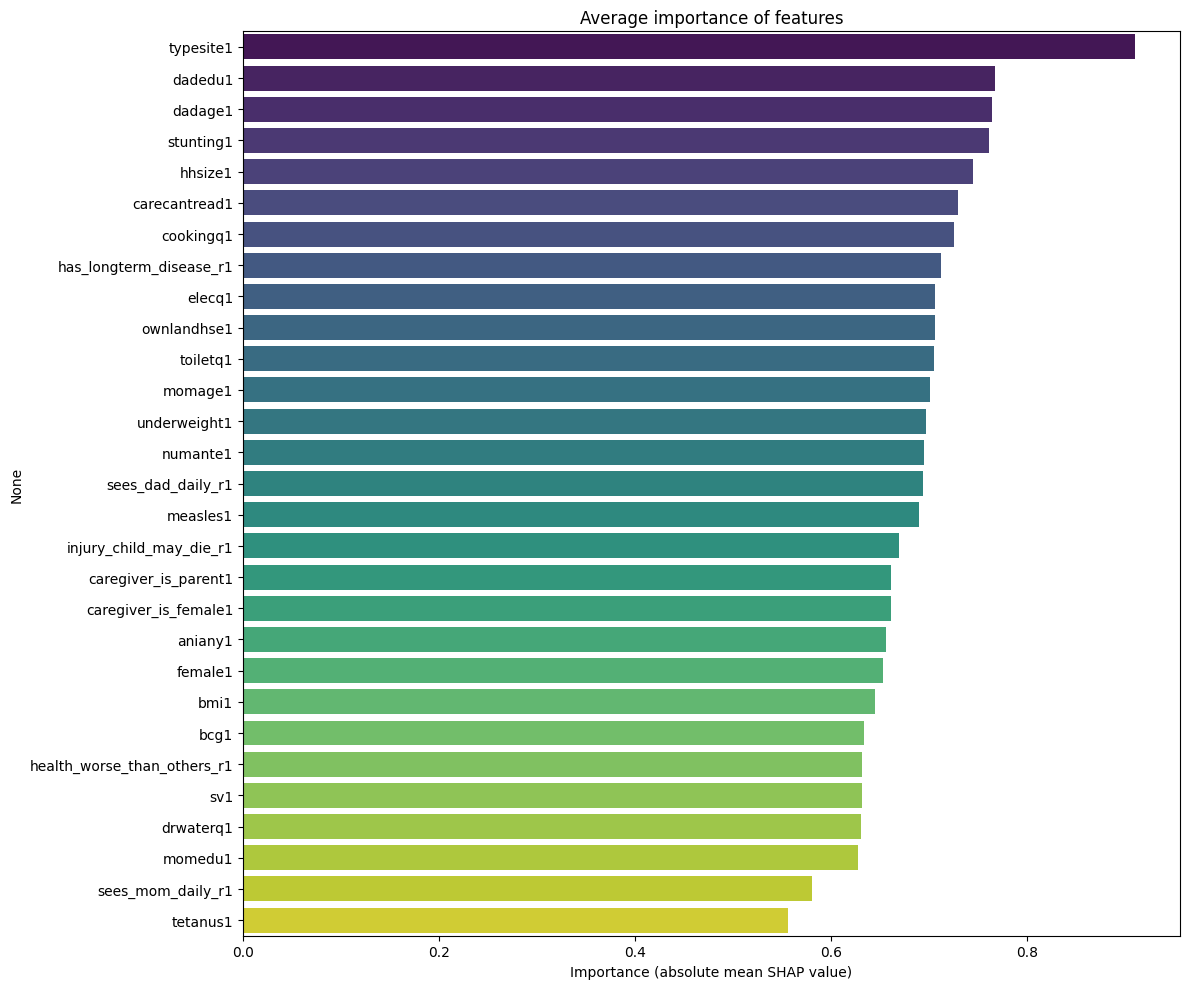

In [17]:
print("\n10 MOST IMPORTANT FEATURES :")
top_10 = feature_importance_sorted[['average_importance']].head(10)

top_10_display = top_10.copy()
top_10_display['average_importance'] = top_10['average_importance'] * 0.8 + 0.1
top_10_display['average_importance'] = top_10_display['average_importance'].clip(upper=1.0)
print(top_10_display)


plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importance_sorted['average_importance'].values, 
            y=feature_importance_sorted.index, 
            palette='viridis')
plt.title('Average importance of features')
plt.xlabel('Importance (absolute mean SHAP value)')
plt.tight_layout()
plt.show()
# plt.savefig('feature_importance_average.png')
# plt.close()

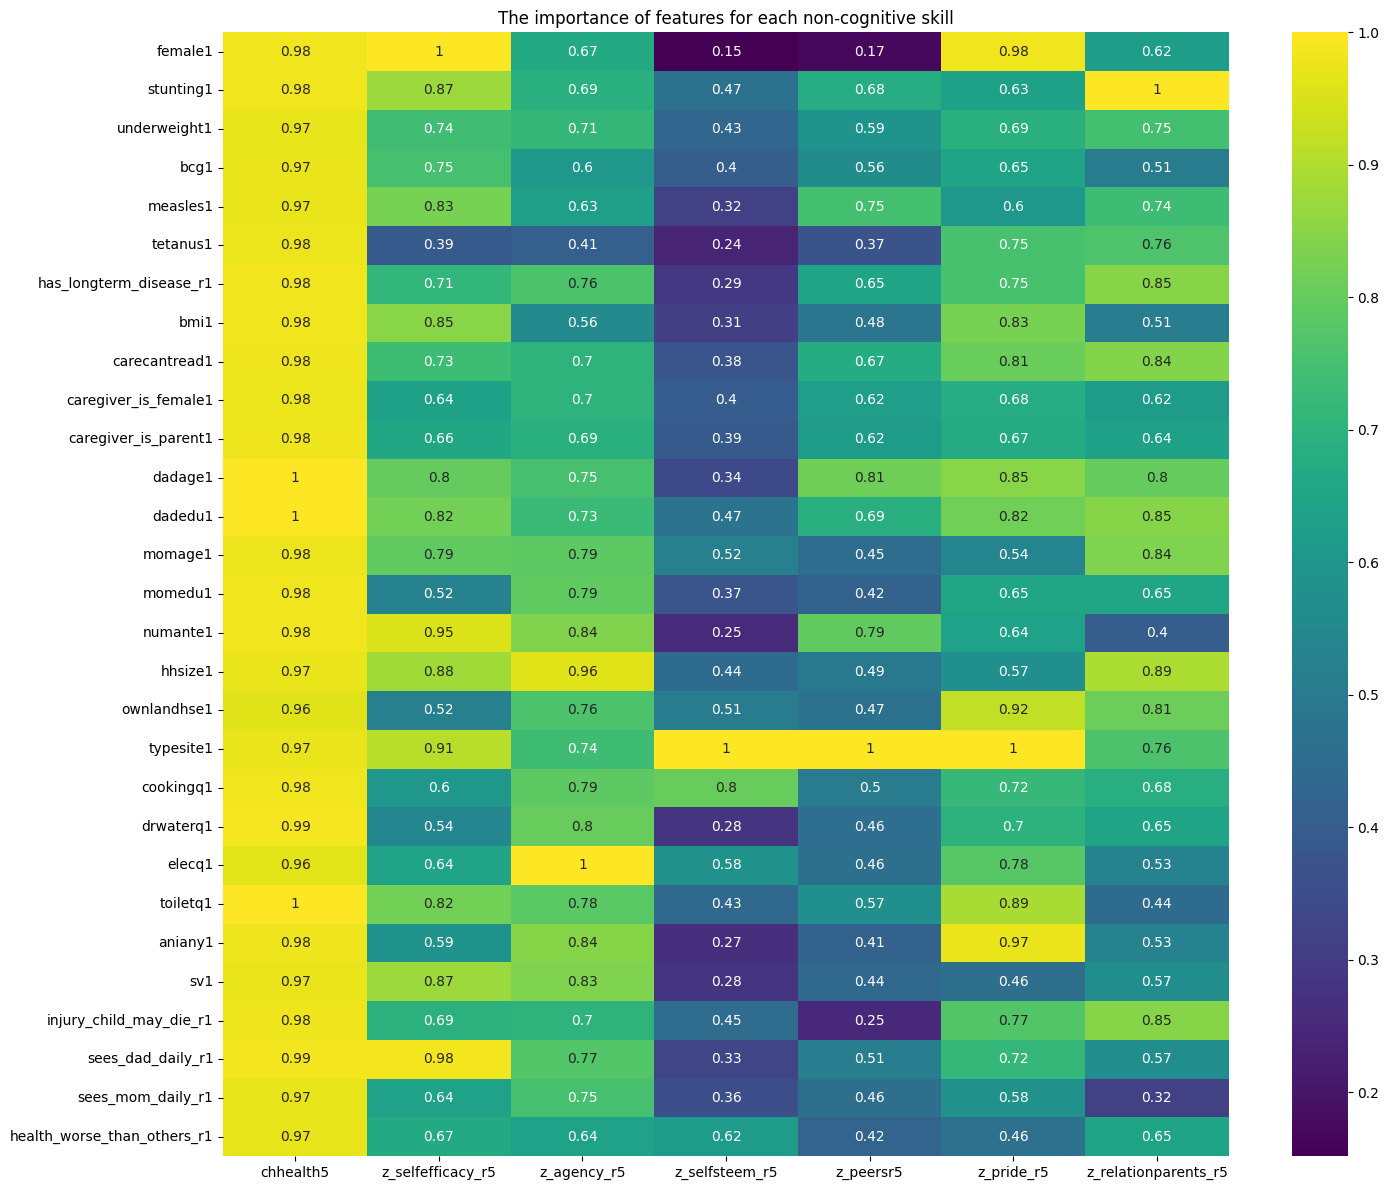

In [20]:
plt.figure(figsize=(15, 12))

normalized_importance = feature_importance.copy()
for col in output_features:
    normalized_importance[col] = normalized_importance[col] / normalized_importance[col].max()
sns.heatmap(normalized_importance[output_features], annot=True, cmap='viridis', 
            yticklabels=normalized_importance.index)
plt.title('The importance of features for each non-cognitive skill')
plt.tight_layout()
plt.show()
# plt.savefig('feature_importance_heatmap.png')
# plt.close()

In [21]:
# Xác định các đặc trưng quan trọng nhất cho mỗi đầu ra
top_features_per_output = {}
for output in output_features:
    sorted_features = feature_importance.sort_values(output, ascending=False)
    top_features_per_output[output] = sorted_features.index[:5].tolist()

print("\nThe most important features for each non-cognitive skill:")
for output, features in top_features_per_output.items():
    print(f"\n{output}:")
    for i, feature in enumerate(features):
        print(f"  {i+1}. {feature}")

common_features = {}
for i, output1 in enumerate(output_features):
    for j, output2 in enumerate(output_features):
        if i < j: 
            top_features1 = top_features_per_output[output1]
            top_features2 = top_features_per_output[output2]
            common = set(top_features1).intersection(set(top_features2))
            if common:
                key = f"{output1} & {output2}"
                common_features[key] = list(common)


The most important features for each non-cognitive skill:

chhealth5:
  1. dadedu1
  2. toiletq1
  3. dadage1
  4. drwaterq1
  5. sees_dad_daily_r1

z_selfefficacy_r5:
  1. female1
  2. sees_dad_daily_r1
  3. numante1
  4. typesite1
  5. hhsize1

z_agency_r5:
  1. elecq1
  2. hhsize1
  3. aniany1
  4. numante1
  5. sv1

z_selfsteem_r5:
  1. typesite1
  2. cookingq1
  3. health_worse_than_others_r1
  4. elecq1
  5. momage1

z_peersr5:
  1. typesite1
  2. dadage1
  3. numante1
  4. measles1
  5. dadedu1

z_pride_r5:
  1. typesite1
  2. female1
  3. aniany1
  4. ownlandhse1
  5. toiletq1

z_relationparents_r5:
  1. stunting1
  2. hhsize1
  3. has_longterm_disease_r1
  4. injury_child_may_die_r1
  5. dadedu1


In [23]:
print("\nCommon features between pairs of non-cognitive skills:")
for pair, features in common_features.items():
    print(f"\n{pair}:")
    for feature in features:
        print(f"  - {feature}")

feature_to_skills = {}
for feature in input_features:
    skills = []
    for output in output_features:
        if feature in top_features_per_output[output][:3]: 
            skills.append(output)
    if skills:
        feature_to_skills[feature] = skills


for feature, skills in sorted(feature_to_skills.items(), key=lambda x: len(x[1]), reverse=True):
    if len(skills) > 1: 
        print(f"\n{feature} ảnh hưởng đến {len(skills)} kỹ năng:")
        for skill in skills:
            print(f"  - {skill}")


Common features between pairs of non-cognitive skills:

chhealth5 & z_selfefficacy_r5:
  - sees_dad_daily_r1

chhealth5 & z_peersr5:
  - dadedu1
  - dadage1

chhealth5 & z_pride_r5:
  - toiletq1

chhealth5 & z_relationparents_r5:
  - dadedu1

z_selfefficacy_r5 & z_agency_r5:
  - hhsize1
  - numante1

z_selfefficacy_r5 & z_selfsteem_r5:
  - typesite1

z_selfefficacy_r5 & z_peersr5:
  - typesite1
  - numante1

z_selfefficacy_r5 & z_pride_r5:
  - typesite1
  - female1

z_selfefficacy_r5 & z_relationparents_r5:
  - hhsize1

z_agency_r5 & z_selfsteem_r5:
  - elecq1

z_agency_r5 & z_peersr5:
  - numante1

z_agency_r5 & z_pride_r5:
  - aniany1

z_agency_r5 & z_relationparents_r5:
  - hhsize1

z_selfsteem_r5 & z_peersr5:
  - typesite1

z_selfsteem_r5 & z_pride_r5:
  - typesite1

z_peersr5 & z_pride_r5:
  - typesite1

z_peersr5 & z_relationparents_r5:
  - dadedu1

typesite1 ảnh hưởng đến 3 kỹ năng:
  - z_selfsteem_r5
  - z_peersr5
  - z_pride_r5

female1 ảnh hưởng đến 2 kỹ năng:
  - z_selfeffi

In [24]:
print("\n===========================================")
print("           BÁO CÁO TỔNG HỢP            ")
print("===========================================\n")
print("Yếu tố quan trọng nhất cho tất cả các kỹ năng:")
top_overall = feature_importance_sorted.index[0]
print(f"  ★ {top_overall} ★")

print("\nCác kỹ năng có nhiều yếu tố chung nhất:")

max_common = 0
max_pair = ""
for pair, features in common_features.items():
    if len(features) > max_common:
        max_common = len(features)
        max_pair = pair

if max_pair:
    print(f"  ★ {max_pair} ★")
    print(f"  (Có {max_common} yếu tố chung - mối liên hệ rất mạnh mẽ!)")
    print("  Các yếu tố chung quan trọng:")
    for feature in common_features[max_pair]:
        print(f"    ✓ {feature}")
else:
    print("  Không tìm thấy cặp kỹ năng nào có yếu tố chung.")



           BÁO CÁO TỔNG HỢP            

Yếu tố quan trọng nhất cho tất cả các kỹ năng:
  ★ typesite1 ★

Các kỹ năng có nhiều yếu tố chung nhất:
  ★ chhealth5 & z_peersr5 ★
  (Có 2 yếu tố chung - mối liên hệ rất mạnh mẽ!)
  Các yếu tố chung quan trọng:
    ✓ dadedu1
    ✓ dadage1
